In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.4380],
         [ 1.7967]]),
 tensor([[ 1.0000e+00, -1.4380e+00,  1.0339e+00, -4.9560e-01,  1.7817e-01,
          -5.1241e-02,  1.2281e-02, -2.5229e-03,  4.5349e-04, -7.2457e-05,
           1.0419e-05, -1.3621e-06,  1.6323e-07, -1.8055e-08,  1.8545e-09,
          -1.7779e-10,  1.5979e-11, -1.3516e-12,  1.0798e-13, -8.1725e-15],
         [ 1.0000e+00,  1.7967e+00,  1.6140e+00,  9.6664e-01,  4.3419e-01,
           1.5602e-01,  4.6720e-02,  1.1992e-02,  2.6932e-03,  5.3764e-04,
           9.6597e-05,  1.5778e-05,  2.3623e-06,  3.2649e-07,  4.1900e-08,
           5.0187e-09,  5.6356e-10,  5.9562e-11,  5.9452e-12,  5.6219e-13]]),
 tensor([-2.9055,  7.0761]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1)%20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss),
                                  evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.028212   1.2760316 -3.4379463  5.4240913]]


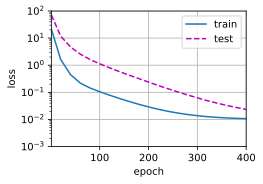

In [6]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.109868 3.994055]]


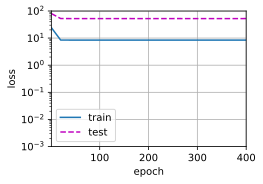

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.986928    1.3540967  -3.264874    5.0356054  -0.54041207  0.81701183
   0.01772026  0.18761419  0.08587196 -0.2061772   0.13668083  0.11044599
  -0.03846828 -0.13442601 -0.10680974 -0.17272028  0.08989908  0.11989239
  -0.03318188 -0.04632139]]


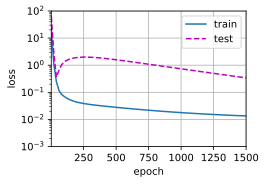

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], 1500)